In [1]:
from laspy.file import File
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the data using laspy
inFile = File('172201/10552_NYU_M2 - Scanner 1 - 190511_172201_1 - originalpoints.las', mode='r')

I = inFile.Classification == 2

# raw is a 1-D numpy array, each entry is a point
raw = inFile.get_points()
print(len(raw))

18942131


In [3]:
raw[4]

((975339267, 173116486, 16325, 1243, 17, 0, 0, 0, 5045, 30, 62541.08084283, 1, 540, 120, 18187., 7.77686e-05, -0.00010587, 7.210951e-05),)

In [4]:
def split_and_strip(raw):
    '''Function takes the output ndarray of laspy File.get_points(), 
        splits each point on commas, 
        outputs a list of lists.'''
    output_list = []
    for row in raw:
        stripped = [a.strip("( , )") for a in str(row).split(',')]
        output_list.append(stripped)
    return output_list

def row_clean(string_list):
    '''Function takes as input a list of lists, the output of split_and_strip().  Cleans the entries for spaces,
    returns a numpy array where each row is a point.'''
    output_list = []
    for row in string_list:        
        output_list.append(list(map(float,row[:-1])))
    output_arr = np.array(output_list)
    return output_arr

In [5]:
string_list = split_and_strip(raw[:10000])
clean_arr = row_clean(string_list)

In [6]:
columns = [
    'Easting',
    'Northing',
    'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R'
]

In [7]:
def summ_stats(array):
    mean = array.mean(axis=0)
    sd = array.std(axis=0)
    max_val = array.max(axis=0)
    min_val = array.min(axis=0)
    print("Mean \t\t Std Dev \t\t Max \t\t Min")
    for m,s,x,n in zip(mean,sd,max_val,min_val):
        print("{:2.2f},\t{:2.2f},\t{:2.2f},\t{:2.2f}".format(m,s,x,n))
summ_stats(clean_arr)

Mean 		 Std Dev 		 Max 		 Min
975191874.93,	90527.46,	975347141.00,	974983464.00
173556554.65,	266223.64,	174129934.00,	173106395.00
19819.79,	16987.60,	58908.00,	-509749.00
1553.69,	403.85,	3055.00,	0.00
18.47,	5.46,	68.00,	17.00
0.19,	4.95,	128.00,	0.00
0.00,	0.00,	0.00,	0.00
0.00,	0.00,	0.00,	0.00
1469.30,	2298.92,	5116.00,	-3218.00
30.00,	0.00,	30.00,	30.00
62541.11,	0.02,	62541.13,	62541.08
1.67,	3.83,	42.00,	1.00
573101.17,	330527.19,	1144802.00,	60.00
119.39,	12.08,	240.00,	38.00
18192.66,	3821.29,	79011.00,	7045.00
0.00,	0.00,	0.00,	-0.00
-0.00,	0.00,	0.00,	-0.00
0.00,	0.00,	0.00,	0.00


In [8]:
clean_df = pd.DataFrame(clean_arr,columns=columns)

In [9]:
clean_df.head(25)

,Easting,Northing,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R
0,975340294.0,173113464.0,16421.0,1159.0,17.0,128.0,0.0,0.0,5066.0,30.0,62541.080832,1.0,60.0,120.0,17090.0,0.000078,-0.000106,0.000072
1,975340029.0,173114239.0,16354.0,1169.0,17.0,0.0,0.0,0.0,5060.0,30.0,62541.080835,1.0,180.0,120.0,16451.0,0.000078,-0.000106,0.000072
2,975339779.0,173114982.0,16385.0,1263.0,17.0,0.0,0.0,0.0,5056.0,30.0,62541.080838,1.0,300.0,120.0,15649.0,0.000078,-0.000106,0.000072
3,975339514.0,173115761.0,16338.0,1290.0,17.0,0.0,0.0,0.0,5050.0,30.0,62541.080840,1.0,420.0,120.0,18946.0,0.000078,-0.000106,0.000072
4,975339267.0,173116486.0,16325.0,1243.0,17.0,0.0,0.0,0.0,5045.0,30.0,62541.080843,1.0,540.0,120.0,18187.0,0.000078,-0.000106,0.000072
5,975339023.0,173117208.0,16314.0,1295.0,17.0,0.0,0.0,0.0,5040.0,30.0,62541.080845,1.0,660.0,120.0,17482.0,0.000078,-0.000106,0.000072
6,975338779.0,173117927.0,16293.0,1276.0,17.0,0.0,0.0,0.0,5035.0,30.0,62541.080848,1.0,780.0,120.0,16805.0,0.000078,-0.000106,0.000072
7,975338500.0,173118750.0,16306.0,1346.0,17.0,0.0,0.0,0.0,5030.0,30.0,62541.080851,1.0,900.0,120.0,15953.0,0.000078,-0.000106,0.000072
8,975338238.0,173119529.0,16352.0,1473.0,17.0,0.0,0.0,0.0,5024.0,30.0,62541.080853,1.0,1020.0,120.0,19235.0,0.000078,-0.000106,0.000072
9,975337996.0,173120238.0,16255.0,1414.0,17.0,0.0,0.0,0.0,5019.0,30.0,62541.080856,1.0,1140.0,120.0,18565.0,0.000078,-0.000106,0.000072


In [10]:
clean_df.describe()

,Easting,Northing,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R
count,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.0,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,9.751919e+08,1.735566e+08,19819.789700,1553.686000,18.468500,0.192000,0.0,0.0,1469.301200,30.0,62541.105822,1.665700,5.731012e+05,119.394200,18192.663700,0.000035,-0.000048,3.484741e-05
std,9.053199e+04,2.662370e+05,16988.449699,403.873469,5.456994,4.953947,0.0,0.0,2299.038561,0.0,0.015411,3.828996,3.305437e+05,12.078741,3821.481525,0.000047,0.000123,2.071007e-05
min,9.749835e+08,1.731064e+08,-509749.000000,0.000000,17.000000,0.000000,0.0,0.0,-3218.000000,30.0,62541.080832,1.000000,6.000000e+01,38.000000,7045.000000,-0.000109,-0.000145,9.916890e-07
25%,9.751265e+08,1.733473e+08,9760.750000,1408.000000,17.000000,0.000000,0.0,0.0,-204.250000,30.0,62541.091237,1.000000,2.880700e+05,120.000000,16623.000000,-0.000025,-0.000133,1.610720e-05
50%,9.751944e+08,1.735513e+08,12883.000000,1615.000000,17.000000,0.000000,0.0,0.0,1623.500000,30.0,62541.105378,1.000000,5.727760e+05,120.000000,17741.000000,0.000059,-0.000120,3.496614e-05
75%,9.752634e+08,1.737483e+08,31830.500000,1826.000000,17.000000,0.000000,0.0,0.0,3391.000000,30.0,62541.119666,1.000000,8.593880e+05,120.000000,18862.000000,0.000070,0.000142,5.085231e-05
max,9.753471e+08,1.741299e+08,58908.000000,3055.000000,68.000000,128.000000,0.0,0.0,5116.000000,30.0,62541.133830,42.000000,1.144802e+06,240.000000,79011.000000,0.000078,0.000144,1.058100e-04


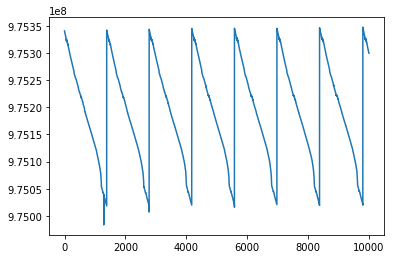

In [11]:
plt.plot(clean_df['Easting'])

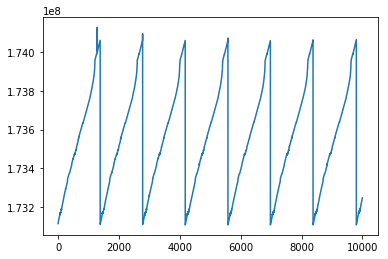

In [12]:
plt.plot(clean_df['Northing'])

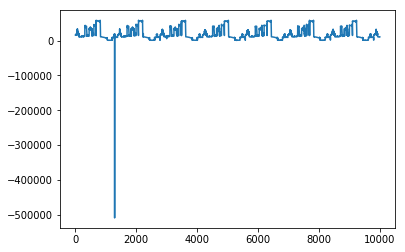

In [13]:
plt.plot(clean_arr[:,2])

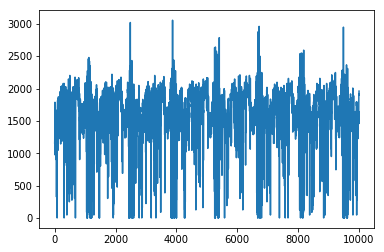

In [14]:
plt.plot(clean_arr[:,3])

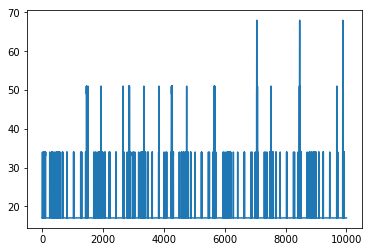

In [15]:
plt.plot(clean_arr[:,4])

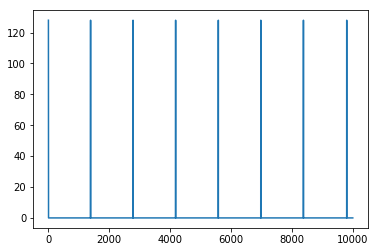

In [16]:
plt.plot(clean_arr[:,5])

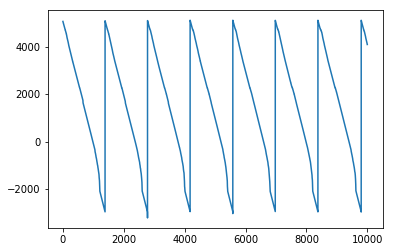

In [17]:
plt.plot(clean_arr[:,8])

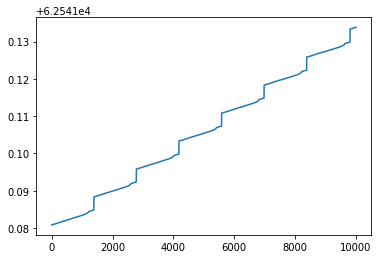

In [18]:
plt.plot(clean_arr[:,10])

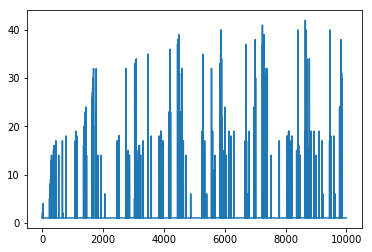

In [19]:
plt.plot(clean_arr[:,11])

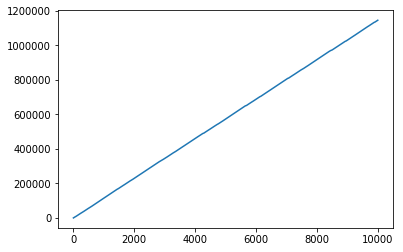

In [20]:
plt.plot(clean_arr[:,12])

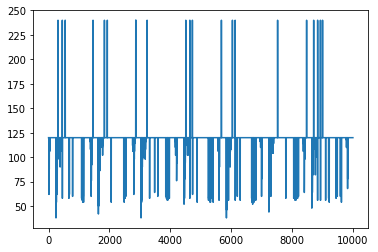

In [21]:
plt.plot(clean_arr[:,13])

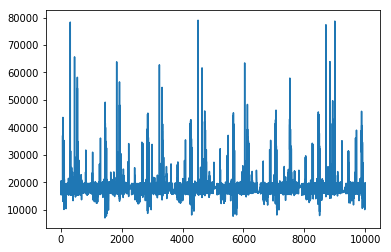

In [22]:
plt.plot(clean_arr[:,14])

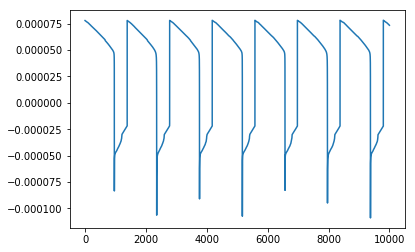

In [23]:
plt.plot(clean_arr[:,15])

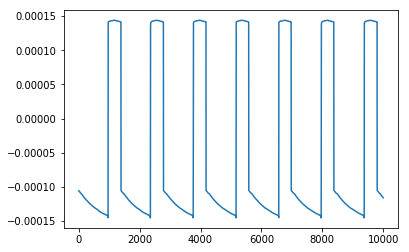

In [24]:
plt.plot(clean_arr[:,16])

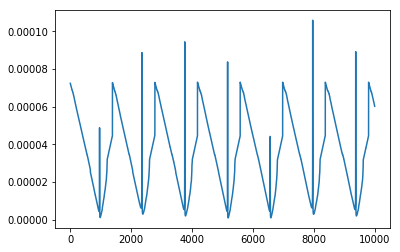

In [25]:
plt.plot(clean_arr[:,17])

In [29]:
import pypwaves

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("ERROR: Pulse number outside the range of expected values")? (pypwaves.py, line 99)